# Importing Libraries

In [1]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 59.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 24.4 MB/s eta 0:00:00


In [2]:
import os
import time
import datetime
import random
import json
import IPython

from google.colab import drive

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from transformers import AutoModelForSequenceClassification,RobertaForSequenceClassification
from transformers import AutoConfig
from transformers import AdamW
from transformers import AutoTokenizer, RobertaTokenizer
from transformers import get_linear_schedule_with_warmup

import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Connecting GPU devices and our Google Drive

In [3]:
# Empty cache of GPU
torch.cuda.empty_cache()

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

drive.mount('/content/drive')

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Mounted at /content/drive


# Loading and Pre-processing Data

In [12]:
df = pd.read_csv('/content/drive/MyDrive/PreProcessed_Data.csv', header=0)


In [ ]:
# test_df = pd.read_csv('/content/drive/MyDrive/twitter_validation.csv', header=None)
# train_df = pd.read_csv('/content/drive/MyDrive/twitter.csv', header=None)

# test_df.reset_index(drop=True,inplace=True)
# train_df.reset_index(drop=True,inplace=True)

# df = pd.concat([train_df,test_df], axis=0)
# df.drop([0], axis=1, inplace=True)
# df.columns = ['platform','sentiment','text']
# df.sentiment = df.sentiment.map({"Neutral":0, "Irrelevant":0 ,"Positive":1,"Negative":2})
# df = df.dropna(subset=['text']).reset_index(drop=True)

# def text_preprocessing(df,col_name):
#     column = col_name
#     df[column] = df[column].progress_apply(lambda x:str(x).lower())
# #     df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
#     df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
#     df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
# #     df[column] = df[column].progress_apply(lambda x: ps.remove_stopwords(x))
#     df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
#     df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
# #     df[column] = df[column].progress_apply(lambda x: th.make_base(x)) #ran -> run,
#     return(df)
# df = text_preprocessing(df,'text')

# nltk.download('stopwords')

# def remove_stopwords(text):

#   stop_words = nltk.corpus.stopwords.words('english')

#   filtered_text = [word for word in text.split() if word not in stop_words]

#   return ' '.join(filtered_text)

# df['text'] = df['text'].apply(remove_stopwords)

# Setting Up Model and Dataloaders

In [ ]:
# Load the pretrained roberta tokenizer
"""
CHANGE 'model_name' to your respective model to run
"""
#model_name = "roberta-base"
model_name = "distilbert-base-uncased"
# model_name = "bert-base-uncased"


print(f"Loading {model_name} tokenizer...")
#model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=3 )
#tokenizer = AutoTokenizer.from_pretrained(model_name)

from transformers import DistilBertTokenizer
from transformers import DistilBertForSequenceClassification

# Load our trained model and vocabulary
drive.mount('/content/drive', force_remount=True)
output_dir = f"./drive/MyDrive/{model_name}/"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name ,num_labels=3,output_attentions = False,
                                     output_hidden_states =  False)


# Add dropout to the model
model.to(device)

Loading distilbert-base-uncased tokenizer...
Mounted at /content/drive


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [13]:
texts = df.text.values
label_cats = df.sentiment.astype('category').cat
# List of label names (str)
label_names = label_cats.categories

# List of label ids (int, in range (0,num_classes-1))
labels = label_cats.codes

# Tokenize all of the sentences and map the tokens to their word IDs
input_ids = []
attention_masks = []

for text in texts:
    encoded_dict = tokenizer.encode_plus(
                        text,
                        add_special_tokens = True,
                        max_length = 256,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt')

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels, dtype=torch.long)

# Print sentence 0, now as a list of IDs.
# print('Original: ', texts[0])
# print('Token IDs:', input_ids[0])
# print('Attention Mask:', attention_masks[0]) # 1 for all text tokens, 0 for all padding tokens

In [ ]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 60-20-20 train-validation-test split

# Calculate the number of samples to include in each set.
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print(f"{train_size} training samples")
print(f"{val_size} validation samples")
print(f"{test_size} test samples")

44997 training samples
14999 validation samples
15000 test samples


In [ ]:
# The DataLoader needs to know our batch size for training, so we specify it
# here. For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

# For test the order doesn't matter, so we'll just read them sequentially.
test_dataloader = DataLoader(
            test_dataset,
            sampler = SequentialSampler(test_dataset),
            batch_size = batch_size
        )

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

print('The model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


The model has 104 different named parameters.

==== Embedding Layer ====

distilbert.embeddings.word_embeddings.weight            (30522, 768)
distilbert.embeddings.position_embeddings.weight          (512, 768)
distilbert.embeddings.LayerNorm.weight                        (768,)
distilbert.embeddings.LayerNorm.bias                          (768,)
distilbert.transformer.layer.0.attention.q_lin.weight     (768, 768)

==== First Transformer ====

distilbert.transformer.layer.0.attention.q_lin.bias           (768,)
distilbert.transformer.layer.0.attention.k_lin.weight     (768, 768)
distilbert.transformer.layer.0.attention.k_lin.bias           (768,)
distilbert.transformer.layer.0.attention.v_lin.weight     (768, 768)
distilbert.transformer.layer.0.attention.v_lin.bias           (768,)
distilbert.transformer.layer.0.attention.out_lin.weight   (768, 768)
distilbert.transformer.layer.0.attention.out_lin.bias         (768,)
distilbert.transformer.layer.0.sa_layer_norm.weight           (768,)

In [ ]:
# Number of training epochs. The BERT authors recommend between 2 and 4.
epochs = 3

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

#f1 score
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average = 'weighted')

# Data Dict to be exported to be analysed with other models

In [ ]:
exportJSON = {}

exportJSON[model_name+"_trainTime"] = []
exportJSON[model_name+"_testTime"] = []
exportJSON[model_name+"_valTime"] = []

exportJSON[model_name+"_testAcc"] = []
exportJSON[model_name+"_valAcc"] = []

exportJSON[model_name+"_trainLoss"] = []
exportJSON[model_name+"_valLoss"] = []

exportJSON[model_name+"_f1score"] = []


# Begin Training

In [ ]:
# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 5 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch


        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        outputs = model(input_ids=b_input_ids,
                                         attention_mask=b_input_mask,
                                         labels=b_labels)
        loss = outputs[0]



        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    # Record for exportJSON
    exportJSON[model_name+"_trainTime"].append(time.time() - t0)
    exportJSON[model_name+"_trainLoss"].append(avg_train_loss)


    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
     # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    total_f1score = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
          # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            preds = model(b_input_ids,attention_mask=b_input_mask,labels=b_labels)




        # Accumulate the validation loss.
        total_eval_loss += preds[0].item()

        # Move logits and labels to CPU
        predicted_labels = preds[1].detach().to('cpu').numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(predicted_labels, label_ids)

        #Caluclate the f1 score for this batch of test sentences,and accumulate it over all batches
        total_f1score += f1_score_func(predicted_labels, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    #Calculate the final f1 score for epoch
    avg_f1_score =  total_f1score/ len(validation_dataloader)
    print("  F1 Score: {0:.2f}".format(avg_f1_score))

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record for exportJSON
    exportJSON[model_name+"_valTime"].append(time.time() - t0)
    exportJSON[model_name+"_valAcc"].append(avg_val_accuracy)
    exportJSON[model_name+"_valLoss"].append(avg_val_loss)
    exportJSON[model_name+"_f1score"].append(avg_f1_score)


    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time,
            'F1 Score' : avg_f1_score
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch     5  of  1,407.    Elapsed: 0:00:04.
  Batch    10  of  1,407.    Elapsed: 0:00:05.
  Batch    15  of  1,407.    Elapsed: 0:00:06.
  Batch    20  of  1,407.    Elapsed: 0:00:07.
  Batch    25  of  1,407.    Elapsed: 0:00:08.
  Batch    30  of  1,407.    Elapsed: 0:00:09.
  Batch    35  of  1,407.    Elapsed: 0:00:10.
  Batch    40  of  1,407.    Elapsed: 0:00:11.
  Batch    45  of  1,407.    Elapsed: 0:00:12.
  Batch    50  of  1,407.    Elapsed: 0:00:13.
  Batch    55  of  1,407.    Elapsed: 0:00:14.
  Batch    60  of  1,407.    Elapsed: 0:00:15.
  Batch    65  of  1,407.    Elapsed: 0:00:16.
  Batch    70  of  1,407.    Elapsed: 0:00:17.
  Batch    75  of  1,407.    Elapsed: 0:00:18.
  Batch    80  of  1,407.    Elapsed: 0:00:19.
  Batch    85  of  1,407.    Elapsed: 0:00:20.
  Batch    90  of  1,407.    Elapsed: 0:00:21.
  Batch    95  of  1,407.    Elapsed: 0:00:22.
  Batch   100  of  1,407.    Elapsed: 0:00:23.
  Batch   105  of

# Judging Results

In [ ]:
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time,F1 Score
epoch,,,,,,
1,0.712432,0.558356,0.771418,0:04:52,0:00:32,0.770844
2,0.419217,0.430051,0.838075,0:04:49,0:00:32,0.838476
3,0.262526,0.397957,0.858316,0:04:49,0:00:32,0.858114


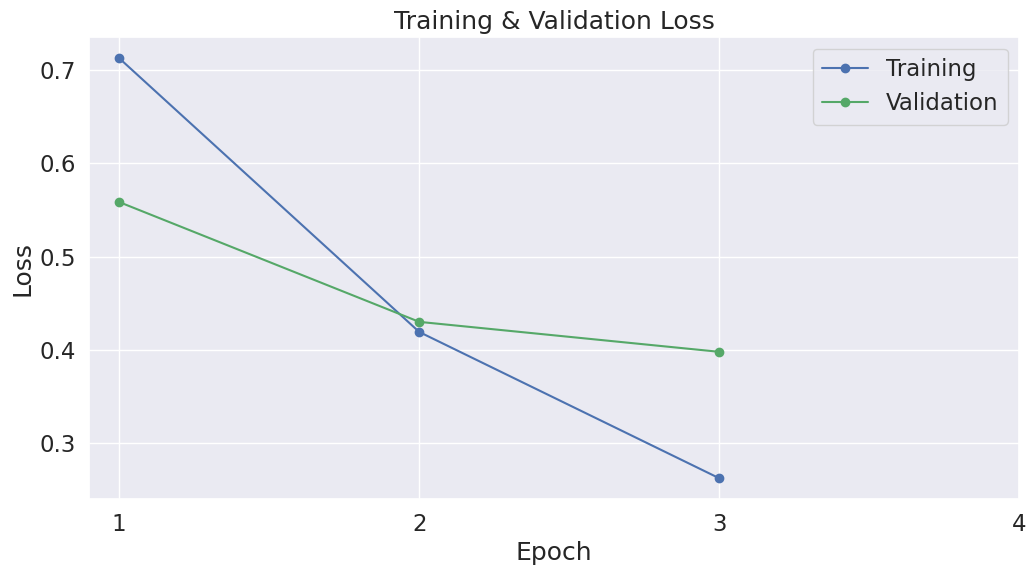

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
# Prediction on test set
print("Predicting labels ...")

# Put model in evaluation mode
model.eval()

startTime = time.time()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(input_ids=b_input_ids,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.extend(logits)
  true_labels.extend(label_ids)

endTime = time.time()

print(f"Predicted {len(predictions)} samples")

Predicting labels ...
Predicted 15000 samples


In [ ]:
predictions = np.argmax(predictions, axis=1)

exportJSON[model_name+"_testTime"].append(endTime-startTime)
exportJSON[model_name+"_testAcc"].append(accuracy_score(true_labels, predictions))

print(f"Test set accuracy: {accuracy_score(true_labels, predictions)}")
print(f"Test set Matthews correlation coefficient: {matthews_corrcoef(true_labels, predictions)}")

Test set accuracy: 0.8586
Test set Matthews correlation coefficient: 0.7842568058242303


#Save Model to Disk

In [ ]:
output_dir = f"./drive/MyDrive/{model_name}/"

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print(f"Saving model to {output_dir}")

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
#torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./drive/MyDrive/distilbert-base-uncased/


('./drive/MyDrive/distilbert-base-uncased/tokenizer_config.json',
 './drive/MyDrive/distilbert-base-uncased/special_tokens_map.json',
 './drive/MyDrive/distilbert-base-uncased/vocab.txt',
 './drive/MyDrive/distilbert-base-uncased/added_tokens.json',
 './drive/MyDrive/distilbert-base-uncased/tokenizer.json')

Export JSON data for comparison

In [ ]:
# Specify the file path on Google Drive
json_file_path = "/content/drive/MyDrive/exportJSON_" + model_name + ".json"

# Export the dictionary to a JSON file on Google Drive
with open(json_file_path, 'w') as json_file:
    json.dump(exportJSON, json_file, indent=4)

#Load Model From Disk

In [8]:

from google.colab import drive
from transformers import DistilBertForSequenceClassification

model_name = "distilbert-base-uncased"

drive.mount('/content/drive', force_remount=True)
output_dir =  f"./drive/MyDrive/{model_name}/"

# Load a trained model and vocabulary that you have fine-tuned

model = DistilBertForSequenceClassification.from_pretrained(model_name ,num_labels=3,output_attentions = True,
                                     output_hidden_states =  False)
tokenizer = AutoTokenizer.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

Mounted at /content/drive


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [55]:
sentences = ["I completed the neural network project!"]


In [56]:
input_ids = []
attention_masks = []

for text in sentences:
  encoded_dict = tokenizer.encode_plus(
                          text,
                          add_special_tokens = True,
                          max_length = 256,
                          pad_to_max_length = True,
                          return_attention_mask = True,
                          return_tensors = 'pt')

  # Add the encoded sentence to the list.
  input_ids.append(encoded_dict['input_ids'])

  # And its attention mask (simply differentiates padding from non-padding).
  attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)

In [57]:
# Put model in evaluation mode
model.eval()

predictions = []
last_layer_attentions = []

# Move input ids and attention masks to GPU
input_ids = input_ids.to(device)
attention_masks = attention_masks.to(device)

for i in range(len(input_ids)):

  ids = input_ids[i].unsqueeze(0)
  masks = attention_masks[i].unsqueeze(0)

  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(input_ids=ids,
                      attention_mask=masks)

  # Get logits and compute softmax
  logits = outputs[0]
  logits = torch.softmax(logits,dim=1)
  last_layer_attention = outputs[1][-1]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  last_layer_attention = last_layer_attention.detach().cpu().numpy()

  last_layer_attentions.append(last_layer_attention)
  predictions.append(logits)

In [58]:
probs = predictions[0][0]
print("text:", sentences[0])
print("predictions:", probs)
pred_idx = np.argmax(probs)
print(f"Prediction: {label_names[pred_idx]} ({probs[pred_idx]:.2f})", )

text: I enjoyed this neural network project, great teammates and great learning experience and i am happy to do this!
predictions: [0.32465485 0.34000984 0.33533528]
Prediction: Neutral/Irrelevant (0.34)


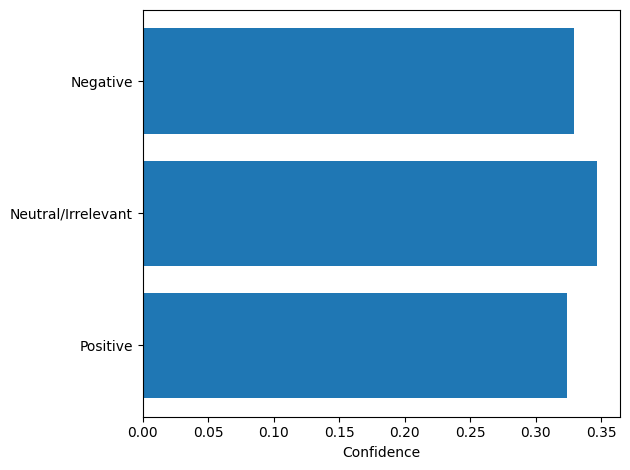

In [54]:
fig = plt.figure(tight_layout=True)
ax = fig.add_subplot(1, 1, 1)

y_pos = np.arange(len(label_names))
confidences = [probs[i] for i in range(len(label_names))]

ax.barh(y_pos, confidences, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(label_names)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Confidence')

fig.show()

#Visualise attentions

In [35]:
lla = last_layer_attentions[0][0][:,0,:]

In [36]:
def avg_token_attentions(last_layer_attentions):
  return last_layer_attentions.mean(axis=0)

In [37]:
avg_token_atts = avg_token_attentions(lla)
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

In [38]:
def handle_special_token_attentions(tokens, avg_token_atts):
  new_tokens = []
  new_avg_token_atts = []
  for i in range(len(tokens)):
    if tokens[i].startswith("[") or tokens[i].startswith("##"):
      continue
    if i < tokenizer.max_len - 1 and tokens[i+1].startswith("##"):
      merged_tokens = tokens[i] + tokens[i+1][2:]
      atts = [avg_token_atts[i], avg_token_atts[i+1]]
      i += 1
      while i < tokenizer.max_len - 1 and tokens[i+1].startswith("##"):
        merged_tokens += tokens[i+1][2:]
        atts.append(avg_token_atts[i+1])
        i += 1
      new_tokens.append(merged_tokens)
      new_avg_token_atts.append(sum(atts)/len(atts))
    elif i < tokenizer.max_len - 1:
      new_tokens.append(tokens[i])
      new_avg_token_atts.append(avg_token_atts[i])
  new_avg_token_atts = new_avg_token_atts / sum(new_avg_token_atts)
  return new_tokens, new_avg_token_atts

In [39]:
for token, att in zip(tokens, avg_token_atts):
  print(token, att)

[CLS] 0.030061258
this 0.057196204
neural 0.026544524
network 0.01672317
assignment 0.036563486
has 0.08311557
been 0.08928266
such 0.073138885
as 0.104862876
fruit 0.042769667
##ful 0.038163077
journey 0.080514304
[SEP] 0.32106435
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0


In [40]:
def scale_color_h_hex(c_h, scale):
    return matplotlib.colors.to_hex(
        matplotlib.colors.hsv_to_rgb((c_h, scale, 1)))

def blue_background_hex(scale):
    return scale_color_h_hex(0.625, scale)

In [41]:
att_html = "<table><tr>"
for token, att in zip(tokens, avg_token_atts):
  att_html += "<td>"
  att_html += "<span style=\"background-color: " + blue_background_hex(att) + "\">" + token + "</span>"
  att_html += "</td>"
att_html += "</tr>"

In [42]:
IPython.display.HTML(att_html)

[CLS],this,neural,network,assignment,has,been,such,as,fruit,##ful,journey,[SEP],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD]
